In [1]:
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt

In [2]:
def extract_frames(video_file, frame_nums, output_folder):
    '''
    Función para extraer frames de archivo .mp4 y guardarlos como .png
    INPUT: Video file, list with frames indexes, output folder
    OUTPUT: None
    '''
    # Abre el archivo de video
    cap = cv2.VideoCapture(video_file)

    # Verifica si el video se abrió correctamente
    if not cap.isOpened():
        print("Error al abrir el video.")
        return

    # Crea la carpeta de salida si no existe
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Itera sobre los números de frames especificados
    for frame_num in frame_nums:
        # Establece el frame en el número especificado
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
        
        # Lee el frame actual
        ret, frame = cap.read()
        
        # Verifica si se leyó correctamente
        if ret:
            # Convierte el frame a escala de grises
            gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

            # Guarda el frame como imagen PNG en la carpeta de salida
            output_path = os.path.join(output_folder, f"frame_{frame_num}.png")
            cv2.imwrite(output_path, gray_frame)
            print(f"Frame {frame_num} guardado como {output_path}")
        else:
            print(f"No se pudo leer el frame {frame_num}")

    # Cierra el archivo de video
    cap.release()

    return

# Ejemplo de uso
video_file = "/Users/diegosilveracoeff/Downloads/Video_Rami.mp4"
frame_nums = [32, 33]  # Números de frames que deseas extraer
output_folder = "/Users/diegosilveracoeff/Desktop/Fing/DCM"

extract_frames(video_file, frame_nums, output_folder)


Frame 32 guardado como /Users/diegosilveracoeff/Desktop/Fing/DCM/frame_32.png
Frame 33 guardado como /Users/diegosilveracoeff/Desktop/Fing/DCM/frame_33.png


In [3]:
#Armo función resta entre frames

def subtract_and_add_value(img_path1, img_path2, output_path, value=128):
    # Lee las imágenes
    img1 = cv2.imread(img_path1, cv2.IMREAD_GRAYSCALE).astype(np.int16)
    img2 = cv2.imread(img_path2, cv2.IMREAD_GRAYSCALE).astype(np.int16)

    # Verifica si las imágenes se leyeron correctamente
    if img1 is None or img2 is None:
        print("Error al leer las imágenes.")
        return

    # Realiza la resta de las imágenes
    diff_img = img1 - img2

    #Verifico el rango dinámico de la diferencia
    print('Valor mínimo de diferencia: ', np.min(diff_img))
    print('Valor máximo de diferencia: ', np.max(diff_img))
    print(np.where(diff_img == 255))
    print(diff_img[1,16])
    print(img1[1,16])
    print(img2[1,16])

    # Suma el valor especificado a cada píxel
    diff_img_adjusted = np.clip(diff_img + value, -128, 127).astype(np.uint8)

    # Guarda la imagen resultante como PNG
    cv2.imwrite(output_path, diff_img_adjusted)
    print(f"Resultado de la resta ajustado y guardado como {output_path}")

# Ejemplo de uso
img_path1 = "/Users/diegosilveracoeff/Desktop/Fing/DCM/frame_32.png"
img_path2 = "/Users/diegosilveracoeff/Desktop/Fing/DCM/frame_33.png"
output_path = "/Users/diegosilveracoeff/Desktop/Fing/DCM/substract_frames.png"

subtract_and_add_value(img_path1, img_path2, output_path)


Valor mínimo de diferencia:  -217
Valor máximo de diferencia:  221
(array([], dtype=int64), array([], dtype=int64))
-1
6
7
Resultado de la resta ajustado y guardado como /Users/diegosilveracoeff/Desktop/Fing/DCM/substract_frames.png


El rango dinámico de la resta entre los frames me puede quedar entre [-255,255], estoy tomando la decisión de diseño de sumar 128 a todos los píxeles y quedarme con valores entre [0,255]. En vez de quedar todo negro queda con grises, pero en el libro está así. Teóricamente al codificar me importa tener redundancia, sin importar el valor numérico.

Duda: Necesito que quede cerca de 0 o solo redundancia? 

(864, 480, 2)


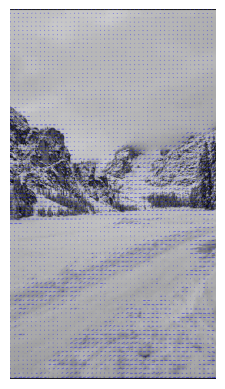

In [4]:
# Pruebo lo de los optical flows

import cv2

# Cargar las dos imágenes de entrada
prev_frame = cv2.imread('/Users/diegosilveracoeff/Desktop/Fing/DCM/frame_32.png')
curr_frame = cv2.imread('/Users/diegosilveracoeff/Desktop/Fing/DCM/frame_33.png')

# Convertir las imágenes a escala de grises
prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
curr_gray = cv2.cvtColor(curr_frame, cv2.COLOR_BGR2GRAY)

# Configurar parámetros para el cálculo del flujo óptico
flow_parameters = dict(
    pyr_scale=0.5,
    levels=3,
    winsize=15,
    iterations=3,
    poly_n=5,
    poly_sigma=1.2,
    flags=0
)

# Calcular el flujo óptico usando el método de Lucas-Kanade
flow = cv2.calcOpticalFlowFarneback(prev_gray, curr_gray, None, **flow_parameters)

# Visualizar el flujo óptico sobre la imagen actual
flow_visualization = cv2.cvtColor(curr_frame, cv2.COLOR_BGR2RGB)
step = 10  # Espaciado para mostrar los vectores de flujo
for y in range(0, flow_visualization.shape[0], step):
    for x in range(0, flow_visualization.shape[1], step):
        dx, dy = flow[y, x]
        cv2.arrowedLine(flow_visualization, (x, y), (int(x + dx), int(y + dy)), (255, 0, 0), 1)

# Guardar el flujo óptico como una imagen
print(flow.shape)
#flow_image = cv2.normalize(flow, None, 0, 255, cv2.NORM_MINMAX)
np.save('/Users/diegosilveracoeff/Desktop/Fing/DCM/flow_x.npy', flow[..., 0])
np.save('/Users/diegosilveracoeff/Desktop/Fing/DCM/flow_y.npy', flow[..., 1])
cv2.imwrite('/Users/diegosilveracoeff/Desktop/Fing/DCM/optical_flow_visualization.png', flow_visualization)

#TODO: Estudiar cuál es el problema de esta visualización
# Mostrar la imagen con el flujo óptico
plt.imshow(cv2.cvtColor(flow_visualization, cv2.COLOR_BGR2RGB))
plt.axis('off')  # Ocultar ejes
plt.show()
# cv2.waitKey(0)
# cv2.destroyAllWindows()


In [5]:
# Pruebo la motion_correction
# Aplicar el flujo óptico al segundo frame
corrected_frame = np.zeros_like(curr_gray)
# corrected_frame = curr_gray
for y in range(flow.shape[0]):
    for x in range(flow.shape[1]):
        dx, dy = flow[y, x]
        x2 = min(max(x + dx, 0), flow.shape[1] - 1)
        y2 = min(max(y + dy, 0), flow.shape[0] - 1)
        corrected_frame[int(y2), int(x2)] = curr_gray[y, x]

corrected_frame_npwhere_reference_based = corrected_frame.copy()
# corrected_frame_npwhere_frame_based = corrected_frame.copy()

print(corrected_frame.shape)

for i in range(corrected_frame.shape[0]):
for j in range(corrected_frame.shape[1]):
    corrected_frame_npwhere_reference_based[i][j] = np.where(corrected_frame_npwhere_reference_based[i][j] == 0, prev_gray[i][j], corrected_frame_npwhere_reference_based[i][j])
    # corrected_frame_npwhere_frame_based[i][j] = np.where(corrected_frame_npwhere_frame_based[i][j] == 0, curr_gray[i][j], corrected_frame_npwhere_frame_based[i][j])

# print(np.min(corrected_frame_npwhere_frame_based))
cv2.imwrite('/Users/diegosilveracoeff/Desktop/Fing/DCM/motion_corrected_frame_npwhere_reference_based.png', corrected_frame_npwhere_reference_based)
# cv2.imwrite('/Users/diegosilveracoeff/Desktop/Fing/DCM/motion_corrected_frame_npwhere_frame_based.png', corrected_frame_npwhere_frame_based)

(864, 480)


True

Acá estaba trabajando con dos opciones para sustituir los valores negros, siendo uno tomar los valores originales del frame de referencia, y otro tomando los valores originales del frame actual. Este último no tiene sentido, dado que el decodificador no va a contar con el frame actual, por lo que queda descartado.

In [6]:
# Cargar las dos imágenes de entrada
ref_frame_path = '/Users/diegosilveracoeff/Desktop/Fing/DCM/frame_32.png'
current_frame_path = '/Users/diegosilveracoeff/Desktop/Fing/DCM/frame_33.png'
corrected_frame_path = '/Users/diegosilveracoeff/Desktop/Fing/DCM/motion_corrected_frame_npwhere_reference_based.png'
output_path = "/Users/diegosilveracoeff/Desktop/Fing/DCM/substract_frames_corrected.png"

subtract_and_add_value(ref_frame_path,corrected_frame_path, output_path)

Valor mínimo de diferencia:  -227
Valor máximo de diferencia:  228
(array([], dtype=int64), array([], dtype=int64))
-1
6
7
Resultado de la resta ajustado y guardado como /Users/diegosilveracoeff/Desktop/Fing/DCM/substract_frames_corrected.png


In [7]:
#Chequeo la energía de cada diferencia

diff_original = cv2.imread('/Users/diegosilveracoeff/Desktop/Fing/DCM/substract_frames.png')
diff_corrected = cv2.imread('/Users/diegosilveracoeff/Desktop/Fing/DCM/substract_frames_corrected.png')

energy_diff_original = np.sum(np.abs(diff_original))
energy_diff_corrected = np.sum(np.abs(diff_corrected))

print(energy_diff_original)
print(energy_diff_corrected)

153181272
152932254


Bajo, eso es bueno. Bajo poco igual, no sé si esta bien...

/var/folders/7k/z98j0trx4dq0tjk9hr7fbwxw0000gn/T/ipykernel_42860/2527230459.py:9: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(np.abs(dct_diff)), cmap='gray', vmin=0, vmax=np.log(np.max(np.abs(dct_diff))))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


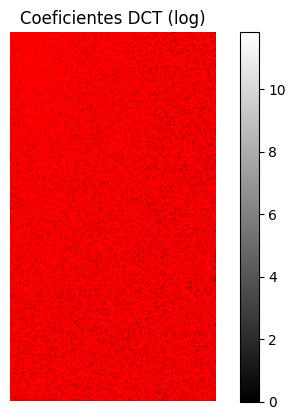

In [8]:
#Modulo de DCT
from scipy.fftpack import dctn

# Ejemplo de cálculo de la DCT
data = np.array([...])  # Tu arreglo de datos
dct_diff = dctn(diff_original, norm='ortho')  # DCT tipo 2


plt.imshow(np.log(np.abs(dct_diff)), cmap='gray', vmin=0, vmax=np.log(np.max(np.abs(dct_diff))))
plt.colorbar()
plt.title('Coeficientes DCT (log)')
plt.axis('off')  # Ocultar ejes
plt.show()


In [5]:
import numpy as np

print(int(3.4))
print(int(3.7))
print(np.trunc(3.4))
print(np.trunc(3.8))

3
3
3.0
3.0


In [6]:
a = np.array([1,2,3])
b = np.array([4,5,6])

print(a-7+b)

[-2  0  2]


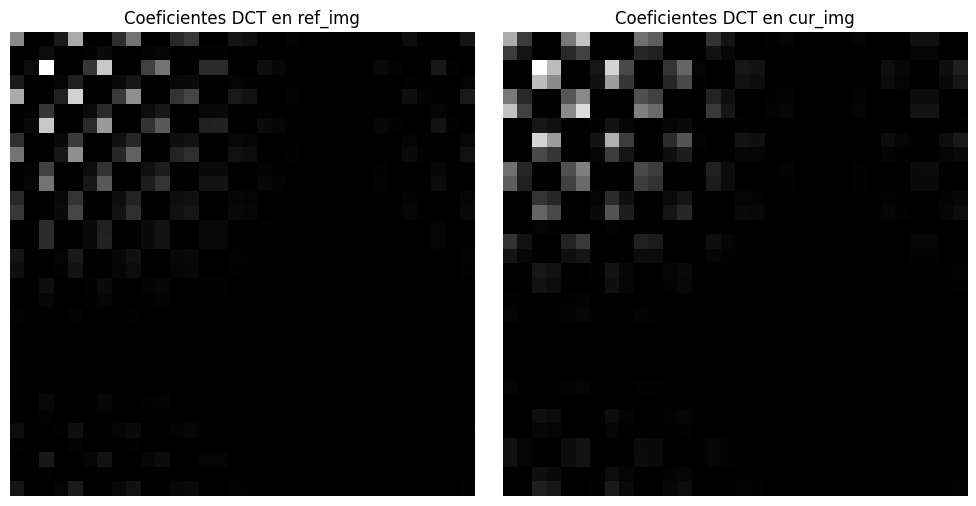

In [2]:
#Modulo de DCT
from scipy.fftpack import dctn
import cv2
from matplotlib import pyplot as plt
import numpy as np

#Leo imagenes de prueba
current_frame_path = '/Users/diegosilveracoeff/Desktop/Fing/DCM/Synthetic_Gaussian/DCM_7x7_image.png'
current_frame_image = cv2.imread(current_frame_path, cv2.IMREAD_GRAYSCALE).astype(np.int16)
ref_frame_path = '/Users/diegosilveracoeff/Desktop/Fing/DCM/Synthetic_Gaussian/DCM_reference_image.png'
ref_frame_image = cv2.imread(ref_frame_path, cv2.IMREAD_GRAYSCALE).astype(np.int16)


# Ejemplo de cálculo de la DCT
#data = np.array([...])  # Tu arreglo de datos
dctn_ref = dctn(ref_frame_image, norm='ortho')  # DCT tipo 2
dctn_cur = dctn(current_frame_image, norm='ortho')  # DCT tipo 2

cv2.imwrite('/Users/diegosilveracoeff/Desktop/Fing/DCM/Synthetic_Gaussian/DCT_ref_frame.png',dctn_ref)
cv2.imwrite('/Users/diegosilveracoeff/Desktop/Fing/DCM/Synthetic_Gaussian/DCT_cur_frame.png',dctn_cur)

# Crear figura y ejes para los subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Subplot 1
axs[0].imshow(dctn_ref, cmap='gray', vmin=0, vmax=np.max(dctn_ref))
axs[0].set_title('Coeficientes DCT en ref_img')
axs[0].axis('off')
#plt.colorbar(ax=axs[0])

# Subplot 2
axs[1].imshow(dctn_cur, cmap='gray', vmin=0, vmax=np.max(dctn_cur))
axs[1].set_title('Coeficientes DCT en cur_img')
axs[1].axis('off')
#plt.colorbar(ax=axs[1])

plt.tight_layout()  # Ajustar espaciado entre subplots
plt.show()

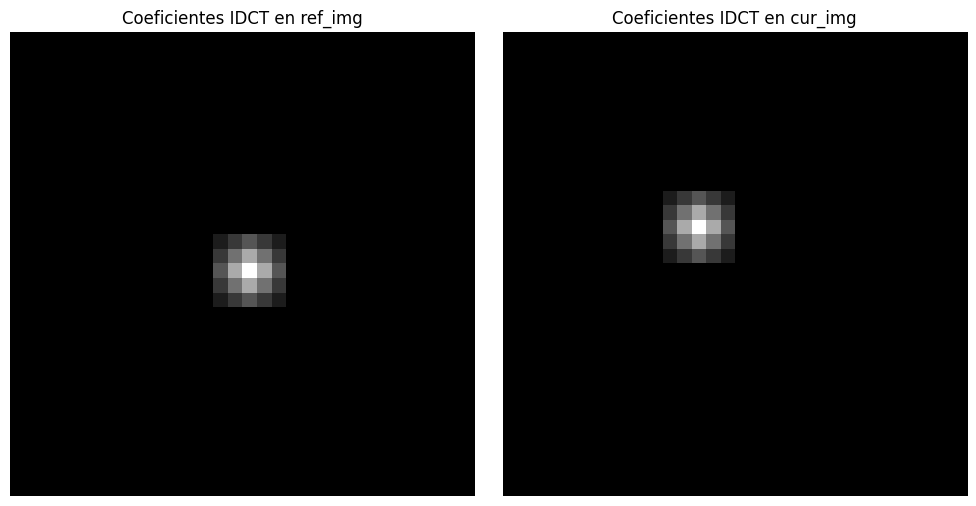

In [3]:
from scipy.fftpack import idctn

# Calcular la inversa de la DCT
idctn_ref = idctn(dctn_ref, norm='ortho')  # Inversa de la DCT tipo 2
idctn_cur = idctn(dctn_cur, norm='ortho')  # Inversa de la DCT tipo 2

cv2.imwrite('/Users/diegosilveracoeff/Desktop/Fing/DCM/Synthetic_Gaussian/IDCT_ref_frame.png',idctn_ref)
cv2.imwrite('/Users/diegosilveracoeff/Desktop/Fing/DCM/Synthetic_Gaussian/IDCT_cur_frame.png',idctn_cur)

# Crear figura y ejes para los subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Subplot 1
axs[0].imshow(idctn_ref, cmap='gray', vmin=0, vmax=np.max(idctn_ref))
axs[0].set_title('Coeficientes IDCT en ref_img')
axs[0].axis('off')
#plt.colorbar(ax=axs[0])

# Subplot 2
axs[1].imshow(idctn_cur, cmap='gray', vmin=0, vmax=np.max(idctn_cur))
axs[1].set_title('Coeficientes IDCT en cur_img')
axs[1].axis('off')
#plt.colorbar(ax=axs[1])

plt.tight_layout()  # Ajustar espaciado entre subplots
plt.show()

In [16]:
import huffman

# Crea un árbol de Huffman a partir de las probabilidades
arbol_huffman = huffman.codebook([('A', 11), ('B', 22), ('C', 5.5), ('D', 5.5), ('E', 0)]) #Normaliza

# Imprime la codificación de cada variable
for simbolo, codigo in arbol_huffman.items():
    print(f'Símbolo: {simbolo}, Código Huffman: {codigo}')


Símbolo: A, Código Huffman: 10
Símbolo: B, Código Huffman: 0
Símbolo: C, Código Huffman: 1111
Símbolo: D, Código Huffman: 110
Símbolo: E, Código Huffman: 1110


In [12]:
a = np.array([0,0,0,0,1,1,2,3])
valor_a_contar = 1
print(np.count_nonzero(a == valor_a_contar))

2


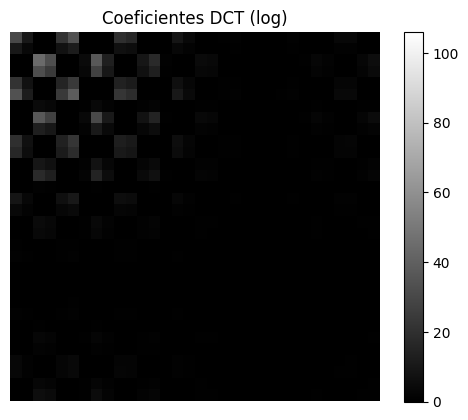

In [13]:
from aux_functions import *

dct_image = cv2.imread('/Users/diegosilveracoeff/Desktop/Fing/DCM/Synthetic_Gaussian/DCT_cur_frame.png')
plot_one_img('/Users/diegosilveracoeff/Desktop/Fing/DCM/Synthetic_Gaussian/DCT_cur_frame.png')

In [87]:
import numpy as np

def contar_pixeles(array_image):
    filas, columnas = array_image.shape
    # Redimensionar el arreglo a una sola dimensión
    array_1d = array_image.reshape(filas * columnas)
    valores, counts = np.unique(array_1d, return_counts=True)
    resultado = [(str(valor), count) for valor, count in zip(valores, counts) if count > 0]
    return resultado

def huffman_codebook(counted_pixels):
    #img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE).astype(np.int16)
    #print(img.shape)
    # Crea un árbol de Huffman a partir de las probabilidades
    arbol_huffman = huffman.codebook(counted_pixels) #Normaliza y devuelve lista

    # Imprime la codificación de cada variable
    simbolos = []
    codigos = []
    for simbolo, codigo in arbol_huffman.items():
        print(f'Símbolo: {simbolo}, Código Huffman: {codigo}')
        simbolos.append(simbolo)
        codigos.append(codigo)

    return np.array([int(simbolo) for simbolo in simbolos]), np.array(codigos)


# Ejemplo de uso
array_imagen = np.array([0,0,0],[0,2,3,6,6]) # Array de ejemplo con valores entre 0 y 255
resultado = contar_pixeles(array_imagen)
print(resultado)
simbolos, codigos = huffman_codebook(resultado)   
print(simbolos, codigos) 

def write_encoded_file(array_imagen, simbolos, codigos, output_path):
    encoded_file = ''
    for i in range(len(array_imagen)):
        j = np.where(simbolos == array_imagen[i])
        print('j: ', j[0][0])
        encoded_file = encoded_file + codigos[j[0][0]]
    print(encoded_file)
    with open(output_path, 'wb') as f:
        # Convertir la cadena de bits en una secuencia de bytes
        byte_data = int(encoded_file, 2).to_bytes((len(encoded_file) + 7) // 8, byteorder='big')
        f.write(byte_data)
    return

#write_encoded_file(simbolos, codigos, '/Users/diegosilveracoeff/Desktop/Fing/DCM/Synthetic_Gaussian/Encoded_reference_image.bin')
    
# Ejemplo de uso

# img_path = '/Users/diegosilveracoeff/Desktop/Fing/DCM/Synthetic_Gaussian/DCM_reference_image.png'
# img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE).astype(np.int16)
# print(img.shape)
# counted_pixels = contar_pixeles(img)
# print(counted_pixels)
# symbols, codes = huffman_codebook(counted_pixels)
# print(symbols, codes)
# write_encoded_file(img, simbolos, codigos, '/Users/diegosilveracoeff/Desktop/Fing/DCM/Synthetic_Gaussian/Encoded_reference_image.bin')


TypeError: Field elements must be 2- or 3-tuples, got '0'

In [48]:
import numpy as np

arr = np.array([5, 6, 7, 1, 2, 3, 4])
indice = np.where(arr == 1)

print("El índice del valor 1 en el arreglo es:", indice)


El índice del valor 1 en el arreglo es: (array([3]),)


In [64]:
a = 'a'
bcd = 'bcd'

print(a+bcd)

abcd


In [23]:
# Datos que queremos escribir en el archivo binario
data = b'Hello, world!'

# Abrir el archivo en modo binario ('wb' para escritura binaria)
with open('archivo_binario.bin', 'wb') as f:
    # Escribir los datos en el archivo
    f.write(data)

print("Datos escritos en el archivo binario.")


Datos escritos en el archivo binario.


In [78]:
# Cadena de bits que queremos escribir en el archivo binario
bit_string = "110010101001011"

# Convertir la cadena de bits en una secuencia de bytes
byte_data = int(bit_string, 2).to_bytes((len(bit_string) + 7) // 8, byteorder='big')

# Abrir el archivo en modo binario ('wb' para escritura binaria)
with open('archivo_binario_bits.bin', 'wb') as f:
    # Escribir los datos en el archivo
    f.write(byte_data)

print("Cadena de bits escrita en el archivo binario.")


Cadena de bits escrita en el archivo binario.


In [31]:
# Cadena de bits que queremos escribir en el archivo binario
bit_string = "011011"

# Convertir la cadena de bits en una secuencia de bytes
byte_data = int(bit_string, 2).to_bytes((len(bit_string) + 7) // 8, byteorder='big')
print(byte_data)

# Abrir el archivo en modo binario ('wb' para escritura binaria)
with open('archivo_binario_bits.bin', 'wb') as f:
    # Escribir los datos en el archivo
    f.write(byte_data)

print("Cadena de bits escrita en el archivo binario.")

# Abrir el archivo binario en modo lectura ('rb' para lectura binaria)
with open('archivo_binario_bits.bin', 'rb') as f:
    # Leer los datos del archivo
    byte_data = f.read()

# Convertir los bytes de vuelta a la cadena de bits
bit_string_recovered = ''.join(format(byte, '08b') for byte in byte_data)

print("Cadena de bits recuperada del archivo binario:", bit_string_recovered)


b'\x1b'
Cadena de bits escrita en el archivo binario.
Cadena de bits recuperada del archivo binario: 00011011


In [37]:
# Cadena de bits que queremos escribir en el archivo binario
bit_string = "1100111001"

# Convertir la cadena de bits en una secuencia de bytes sin relleno
byte_data = bytes([int(bit_string[i:i+8], 2) for i in range(0, len(bit_string), 8)])
print(byte_data)
# # Abrir el archivo en modo binario ('wb' para escritura binaria)
# with open('archivo_binario_bits.bin', 'wb') as f:
#     # Escribir los datos en el archivo
#     f.write(byte_data)

b'\xce\x01'


In [33]:
from bitstring import BitArray

# Crear una cadena binaria de 5 bits
cadena_binaria = '10010'

# Convertir la cadena a un objeto BitArray
bits = BitArray(bin=cadena_binaria)

# Escribir los bits en un archivo binario
with open('archivo.bin', 'wb') as archivo:
    archivo.write(bits.bytes)

# Leer los bits desde el archivo binario
with open('archivo.bin', 'rb') as archivo:
    datos = archivo.read()
    bits_recuperados = BitArray(bytes=datos, length=5)

# Convertir los bits recuperados de nuevo a cadena binaria
cadena_recuperada = bits_recuperados.bin

print(f"Cadena original: {cadena_binaria}")
print(f"Cadena recuperada: {cadena_recuperada}")


ValueError: Cannot interpret as bytes unambiguously - not multiple of 8 bits.

In [34]:
# Importar el módulo necesario
import struct

# Definir la cadena binaria
cadena_binaria = '10010'

# Convertir la cadena binaria a un número entero de 5 bits
numero = int(cadena_binaria, 2)

# Escribir el número en un archivo binario
with open('archivo.bin', 'wb') as archivo:
    archivo.write(struct.pack('B', numero))

# Leer el número desde el archivo binario
with open('archivo.bin', 'rb') as archivo:
    datos = archivo.read()
    numero_recuperado = struct.unpack('B', datos)[0]

# Convertir el número recuperado de nuevo a cadena binaria
cadena_recuperada = bin(numero_recuperado)[2:].zfill(5)

print(f"Cadena original: {cadena_binaria}")
print(f"Cadena recuperada: {cadena_recuperada}")


Cadena original: 10010
Cadena recuperada: 10010


In [92]:
def count_pixel_values(image_path):
    image_array = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    print(image_array.shape)
    rows, columns = image_array.shape
    # Redimensionar el arreglo a una sola dimensión
    array_1d = image_array.reshape(rows * columns)
    values, counts = np.unique(image_array, return_counts=True)
    result = [(str(value), count) for value, count in zip(values, counts) if count > 0]
    return result

def huffman_codebook(counted_pixels):
    #img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE).astype(np.int16)
    #print(img.shape)
    # Crea un árbol de Huffman a partir de las probabilidades
    arbol_huffman = huffman.codebook(counted_pixels) #Normaliza y devuelve lista

    # Imprime la codificación de cada variable
    simbolos = []
    codigos = []
    for simbolo, codigo in arbol_huffman.items():
        print(f'Símbolo: {simbolo}, Código Huffman: {codigo}')
        simbolos.append(simbolo)
        codigos.append(codigo)

    return np.array([int(simbolo) for simbolo in simbolos]), np.array(codigos)

def write_encoded_file(image_path, symbols, codes, output_path):
    encoded_file = ''
    image_array = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    print(image_array.shape)
    rows, columns = image_array.shape
    # Redimensionar el arreglo a una sola dimensión
    array_1d = image_array.reshape(rows * columns)
    for i in range(len(array_1d)):
        j = np.where(symbols == array_1d[i])
        #print('j: ', j[0][0])
        encoded_file = encoded_file + codes[j[0][0]]
    #print(encoded_file)
    print('len(encoded_file): ', len(encoded_file))
    with open(output_path, 'wb') as f:
        # Convertir la cadena de bits en una secuencia de bytes
        byte_data = int(encoded_file, 2).to_bytes((len(encoded_file) + 7) // 8, byteorder='big')
        f.write(byte_data)
    return

In [93]:
reference_frame_path = '/Users/diegosilveracoeff/Desktop/Fing/DCM/Synthetic_Gaussian/DCM_reference_image.png'
counted_pixels = count_pixel_values(reference_frame_path)
print(counted_pixels)
symbols, codes = huffman_codebook(counted_pixels)
print(symbols, codes)
write_encoded_file(reference_frame_path, symbols, codes, '/Users/diegosilveracoeff/Desktop/Fing/DCM/Synthetic_Gaussian/Encoded_reference_image.bin')

(32, 32)
[('0', 999), ('28', 4), ('57', 8), ('85', 4), ('113', 4), ('170', 4), ('255', 1)]
Símbolo: 0, Código Huffman: 1
Símbolo: 28, Código Huffman: 0101
Símbolo: 57, Código Huffman: 011
Símbolo: 85, Código Huffman: 000
Símbolo: 113, Código Huffman: 0100
Símbolo: 170, Código Huffman: 0011
Símbolo: 255, Código Huffman: 0010
[  0  28  57  85 113 170 255] ['1' '0101' '011' '000' '0100' '0011' '0010']
(32, 32)
len(encoded_file):  1087


In [112]:
#Testing encoder

string = '10110000101100001011'
cont = 0
while len(string)%8 != 0:
    string = '0' + string
    cont += 1
print(string)
print(cont)

binario = bin(cont)[2:].zfill(8)  # Convierte el número a binario y elimina el prefijo '0b'
print(binario.zfill(8))

final_string = binario + string
print(final_string)

test_bin_path = '/Users/diegosilveracoeff/Desktop/Fing/DCM/Synthetic_Gaussian/test.bin'
with open(test_bin_path, 'wb') as f:
    # Convertir la cadena de bits en una secuencia de bytes
    byte_data = int(final_string, 2).to_bytes((len(final_string) + 7) // 8, byteorder='big')
    f.write(byte_data)

000010110000101100001011
4
00000100
00000100000010110000101100001011


In [109]:
#Testing decoder

def bytes_a_binario(bytes):
    # Utilizamos la función format() con '08b' para obtener una cadena de bits de 8 dígitos por byte
    return ''.join(format(byte, '08b') for byte in bytes)

test_bin_path = '/Users/diegosilveracoeff/Desktop/Fing/DCM/Synthetic_Gaussian/test.bin'
with open(test_bin_path, 'rb') as archivo:
    contenido = archivo.read()
    contenido_binario = bytes_a_binario(contenido)
    # Aquí puedes procesar el contenido binario según tus necesidades
    print(contenido_binario)



0000010000001011


In [123]:
def bin_to_string(bytes):
    # Utilizamos la función format() con '08b' para obtener una cadena de bits de 8 dígitos por byte
    string = ''.join(format(byte, '08b') for byte in bytes)
    return string

def read_fillout_number(string):
    fillout_number = int(string, 2)
    return fillout_number

def read_and_decode_file(bin_path):
    with open(bin_path, 'rb') as file:
        file_content = file.read()
        decoded_string = bin_to_string(file_content)
        fillout_number = read_fillout_number(decoded_string[:8])
        message = decoded_string[8+fillout_number:]
        print(f'Cadena binaria: {decoded_string}')
        print(f'Primeros 8 bits: {decoded_string[:8]}')
        print(f'Número entero: {fillout_number}')
        print(f'Imagen codificado: {message}')

read_and_decode_file(test_bin_path)

Cadena binaria: 00000100000010110000101100001011
Primeros 8 bits: 00000100
Número entero: 4
Imagen codificado: 10110000101100001011


In [119]:
cadena = 'Hola mundo'
indice_n = 3  # Este es el índice a partir del cual deseas obtener el substring
substring = cadena[indice_n:]

print(substring)  # Esto imprimirá '01010010101'


a mundo
